# Using convnets with small datasets

-  Chapter 8, Section 2 of [Deep Learning with Python](https://www.manning.com/books/deep-learning-with-python?a_aid=keras&a_bid=76564dff)


In [ ]:
# mount drive 
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
from tensorflow import keras
import os
import datetime

## Training a convnet from scratch on a small dataset

Having to train an image classification model using only very little data is a common situation, which you likely encounter yourself in 
practice if you ever do computer vision in a professional context.

Having "few" samples can mean anywhere from a few hundreds to a few tens of thousands of images. As a practical example, we will focus on 
classifying images as "dogs" or "cats", in a dataset containing 3000 pictures of cats and dogs (1500 cats, 1500 dogs). We will use 2000 
pictures for training and 1000 for validation.

In this section, we will review one basic strategy to tackle this problem: **training a new model from scratch on what little data we have**. 

## The relevance of deep learning for small-data problems

You will sometimes hear that deep learning only works when lots of data is available. This is in part a valid point: one fundamental 
characteristic of deep learning is that it is **able to find interesting features in the training data on its own**, without any need for manual 
feature engineering, and this can only be achieved when **lots of training examples are available**. This is especially true for problems where 
the input samples are very high-dimensional, like images.

However, what constitutes "lots" of samples is relative -- relative to the size and depth of the network you are trying to train, for 
starters. It isn't possible to train a convnet to solve a complex problem with just a few tens of samples, but a few hundreds can 
potentially suffice if the model is small and well-regularized and if the task is simple. 
Because **convnets learn local, translation-invariant features**, they are very 
**data-efficient** on perceptual problems. Training a convnet from scratch on a very small image dataset will still yield reasonable results 
despite a relative lack of data, without the need for any custom feature engineering. You will see this in action in this section.

But what's more, deep learning models are by nature **highly repurposable**: you can take, say, an image classification or speech-to-text model 
trained on a large-scale dataset then reuse it on a significantly different problem with only minor changes. Specifically, in the case of 
computer vision, many pre-trained models (usually trained on the ImageNet dataset) are now publicly available for download and can be used 
to bootstrap powerful vision models out of very little data. That's what we will do in the next section.

For now, let's get started by getting our hands on the data.

## Downloading the data

The cats vs. dogs dataset was made available by Kaggle.com as part of a computer vision 
competition in late 2013, back when convnets weren't quite mainstream. 

The pictures are medium-resolution color JPEGs. They look like this:

![cats_vs_dogs_samples](https://s3.amazonaws.com/book.keras.io/img/ch5/cats_vs_dogs_samples.jpg)

Unsurprisingly, the cats vs. dogs Kaggle competition in 2013 was won by entrants who used convnets. The best entries could achieve up to 
95% accuracy. In our own example, we will get fairly close to this accuracy (in the next section), even though we will be training our 
models on less than 10% of the data that was available to the competitors.

This original dataset contains 25,000 images of dogs and cats (12,500 from each class) and is 543MB large (compressed). We will use a subset of the original dataset: a training set with 1000 samples of each class, a validation set with 500 samples of each class.


The **reduced dataset** has the following directory structure: 
```
cats_and_dogs_filtered
|__ train
    |______ cats: [cat.0.jpg, cat.1.jpg, cat.2.jpg ....]
    |______ dogs: [dog.0.jpg, dog.1.jpg, dog.2.jpg ...]
|__ validation
    |______ cats: [cat.2000.jpg, cat.2001.jpg, cat.2002.jpg ....]
    |______ dogs: [dog.2000.jpg, dog.2001.jpg, dog.2002.jpg ...]
```

In [ ]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

68606236/68606236 [==============================] - 4s 0us/step


In [ ]:
os.listdir(PATH)

['vectorize.py', 'validation', 'train']

In [ ]:
train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')
train_cats_dir = os.path.join(train_dir, 'cats')  # directory with our training cat pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')  # directory with our training dog pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')  # directory with our validation cat pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')  # directory with our validation dog pictures

As a sanity check, let's count how many pictures we have in each training split (train / validation).

In [ ]:
num_cats_tr = len(os.listdir(train_cats_dir))
num_dogs_tr = len(os.listdir(train_dogs_dir))

num_cats_val = len(os.listdir(validation_cats_dir))
num_dogs_val = len(os.listdir(validation_dogs_dir))

total_train = num_cats_tr + num_dogs_tr
total_val = num_cats_val + num_dogs_val

In [ ]:
print('total training cat images:', num_cats_tr)
print('total training dog images:', num_dogs_tr)

print('total validation cat images:', num_cats_val)
print('total validation dog images:', num_dogs_val)
print("--")
print("Total training images:", total_train)
print("Total validation images:", total_val)

total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500
--
Total training images: 2000
Total validation images: 1000



So we have indeed 2000 training images and 1000 validation images. In each split, there is the same number of 
samples from each class: this is a balanced binary classification problem, which means that classification accuracy will be an appropriate 
measure of success.

/root/.keras/datasets/cats_and_dogs_filtered/train/dogs


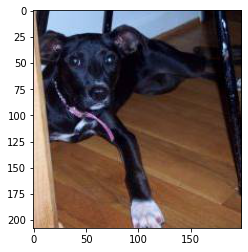

In [ ]:
from PIL import Image
from matplotlib.pyplot import imshow

print(train_dogs_dir)
example_img = os.path.join(train_dogs_dir,os.listdir(train_dogs_dir)[12])
image = Image.open(example_img,'r')
imshow(image)

## Building our network

We've already built a small convnet for MNIST in the previous example, so you should be familiar with them. We will reuse the same 
general structure: our convnet will be a stack of alternated `Conv2D` (with `relu` activation) and `MaxPooling2D` layers.

However, since we are dealing with bigger images and a more complex problem, we will make our network accordingly larger: it will have two 
more `Conv2D` + `MaxPooling2D` stage. This serves both to augment the capacity of the network, and to further reduce the size of the 
feature maps, so that they aren't overly large when we reach the `Flatten` layer. Here, since we start from inputs of size 180x180 (a 
somewhat arbitrary choice), we end up with feature maps of size 7x7 right before the `Flatten` layer.

Note that the depth of the feature maps is progressively increasing in the network (from 32 to 256), while the size of the feature maps is 
decreasing (from 178x178 to 7x7). This is a pattern that you will see in almost all convnets.

Since we are attacking a binary classification problem, we are ending the network with a single unit (a `Dense` layer of size 1) and a 
`sigmoid` activation. This unit will encode the probability that the network is looking at one class or the other.

There are two main differences in the definition of the model, with respect to our previous examples:

1.   The network is defined using the **Functional API**. Differently from the **Sequential API**, it focuses on graph-like model architectures and ensures a high level of usability and flexibility.
    1.   Each layer can return a *symbolic tensor* (it stands for a future tensor of data) and can be called on symbolic tensors.
    2.   At the end, the model is instantiated by specifying its inputs and outputs in the `Model` constructor. It is particularly useful when you need to define models with multiple inputs, multiple outputs or non-linear topology.

2.   We will start the model with a `Rescaling` layer, which will rescale image inputs (whose values are originally in the [0, 255] range) to the [0, 1] range.



In [ ]:
from tensorflow.keras import layers

inputs = keras.Input(shape=(180, 180, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

Let's take a look at how the dimensions of the feature maps change with every successive layer:

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                         

For our compilation step, we'll go with the `rmsprop` optimizer as usual. Since we ended our network with a single sigmoid unit, we will 
use binary crossentropy as our loss.

In [ ]:
from tensorflow.keras import optimizers

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

## Data preprocessing

As you already know by now, data should be formatted into appropriately pre-processed floating point tensors before being fed into our 
network. Currently, our data sits on a drive as JPEG files, so the steps for getting it into our network are roughly:

* Read the picture files.
* Decode the JPEG content to RGB grids of pixels.
* Convert these into floating point tensors.
* Resize them to a shared size (we’ll use 180 × 180)
* Pack them into batches (we’ll use batches of 32 images).

It may seem a bit daunting, but thankfully Keras has utilities to take care of these steps automatically. In particular, Keras features the utility function `image_dataset_from_directory()`, which lets you quickly set up a data pipeline that can automatically turn
image files on disk into batches of preprocessed tensors. This is what we’ll use here.

In [ ]:
BATCH_SIZE = 32
IMAGE_HEIGHT = 180
IMAGE_WIDTH = 180

In [ ]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    os.path.join(PATH, 'train'),
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE)

validation_dataset = image_dataset_from_directory(
    os.path.join(PATH, 'validation'),
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


Calling `image_dataset_from_directory(directory)` will first list the subdirectories
of `directory` and assume each one contains images from one of our classes. It will
then index the image files in each subdirectory. Finally, it will create and return a
`tf.data.Dataset` object configured to read these files, shuffle them, decode them to
tensors, resize them to a shared size, and pack them into batches.

A `Dataset` object is an iterator: you can use it in a for loop. It will typically return
batches of input data and labels. You can pass a `Dataset` object directly to the `fit()`
method of a Keras model.

Let's take a look at the output of one of these `Dataset` objects: it yields batches of 180x180 RGB images (shape `(32, 180, 180, 3)`) and binary 
labels (shape `(32,)`). 32 is the number of samples in each batch (the batch size).


In [ ]:
for data_batch, labels_batch in train_dataset:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

data batch shape: (32, 180, 180, 3)
labels batch shape: (32,)


Let’s fit the model on our dataset. We’ll use the `validation_data` argument in `fit()` to monitor validation metrics on a separate `Dataset` object.

In [ ]:
history = model.fit(
  train_dataset,
  epochs=30,
  validation_data=validation_dataset)

Epoch 1/30
63/63 [==============================] - 16s 93ms/step - loss: 0.7288 - accuracy: 0.5040 - val_loss: 0.6923 - val_accuracy: 0.5190
Epoch 2/30
63/63 [==============================] - 5s 71ms/step - loss: 0.7074 - accuracy: 0.5485 - val_loss: 0.7755 - val_accuracy: 0.5250
Epoch 3/30
63/63 [==============================] - 5s 72ms/step - loss: 0.6953 - accuracy: 0.5680 - val_loss: 0.6916 - val_accuracy: 0.5680
Epoch 4/30
63/63 [==============================] - 5s 70ms/step - loss: 0.6410 - accuracy: 0.6390 - val_loss: 0.7598 - val_accuracy: 0.5380
Epoch 5/30
63/63 [==============================] - 6s 88ms/step - loss: 0.6421 - accuracy: 0.6700 - val_loss: 0.7846 - val_accuracy: 0.6270
Epoch 6/30
63/63 [==============================] - 5s 73ms/step - loss: 0.6035 - accuracy: 0.7025 - val_loss: 0.6309 - val_accuracy: 0.6310
Epoch 7/30
63/63 [==============================] - 5s 72ms/step - loss: 0.5611 - accuracy: 0.7155 - val_loss: 0.5881 - val_accuracy: 0.7120
Epoch 8/30
6

It is good practice to always save your models after training:

In [ ]:
dir_name = "/content/drive/My Drive/[AIDE] 2022-2023 - Data"
if not os.path.exists(dir_name):
  os.makedirs(dir_name)
model.save(os.path.join(dir_name, 'cats_and_dogs_small.h5'))

Let's plot the loss and accuracy of the model over the training and validation data during training:

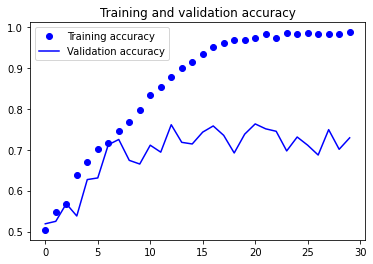

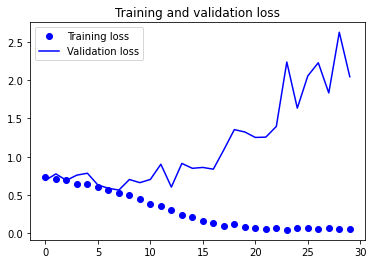

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

These plots are characteristic of overfitting. Our training accuracy increases linearly over time, until it reaches nearly 100%, while our 
validation accuracy stalls at 70%-75%. Our validation loss reaches its minimum after only 5-10 epochs then stalls, whereas the training loss 
keeps decreasing linearly until it reaches nearly 0.

Because we only have relatively few training samples (2000), overfitting is going to be our number one concern. You already know about a 
number of techniques that can help mitigate overfitting, such as dropout and weight decay (L2 regularization). We are now going to 
introduce a new one, specific to computer vision, and used almost universally when processing images with deep learning models: **data augmentation**.

## Early Stopping

Another frequently used form of regularization is represented by **early stopping**: at the end of each epoch we monitor the classification accuracy (or loss) on validation data; when the monitored quantity stops improving, we stop training.

This technique allows to fight overfitting by automatically adjusting the number of training epochs. 

Early-stopping can be easily implemented in tf.keras thanks to the dedicated **callback**, i.e. a utility called at certain points during model training.
From  [tensorflow documentation](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping):

```python
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
# This callback will stop the training when there is no improvement in
# the validation loss for three consecutive epochs.
model.fit(data, labels, epochs=100, callbacks=[callback],
    validation_data=(val_data, val_labels)
```

## Using data augmentation

Overfitting is caused by having too few samples to learn from, preventing us to train a model able to generalize to new data. 

Given infinite data, our model would be exposed to every possible aspect of the data distribution at hand: we would never overfit. Data 
augmentation takes the approach of generating more training data from existing training samples, by **"augmenting" the samples via a number 
of random transformations** that yield believable-looking images. The goal is that at training time, our model would never see the exact same 
picture twice. This helps the model get exposed to more aspects of the data and generalize better.

In Keras, this can be done by adding a number of *data augmentation layers* at the start of our model. Let’s get started with an example: the following `Sequential` model chains several random image transformations. In our model, we’d include it right before the `Rescaling` layer.

In [ ]:
data_augmentation = keras.Sequential([
  layers.RandomFlip("horizontal"), # Applies horizontal flipping to a random 50% of the images
  layers.RandomRotation(0.1), # Rotates the input images by a random value in the range[–10%, +10%] (fraction of full circle [-36°, 36°])
  layers.RandomZoom(0.2), # Zooms in or out of the image by a random factor in the range [-20%, +20%]
])

These are just a few of the options available. 

These layers apply random augmentation transforms to a batch of images. **By default, these transformations are only applied during training. At inference time, the layer does nothing.**

The Keras Documentation provides details about other available layers, including:

    tf.keras.layers.RandomCrop
    tf.keras.layers.RandomFlip
    tf.keras.layers.RandomTranslation
    tf.keras.layers.RandomRotation
    tf.keras.layers.RandomZoom
    tf.keras.layers.RandomHeight
    tf.keras.layers.RandomWidth
    tf.keras.layers.RandomContrast


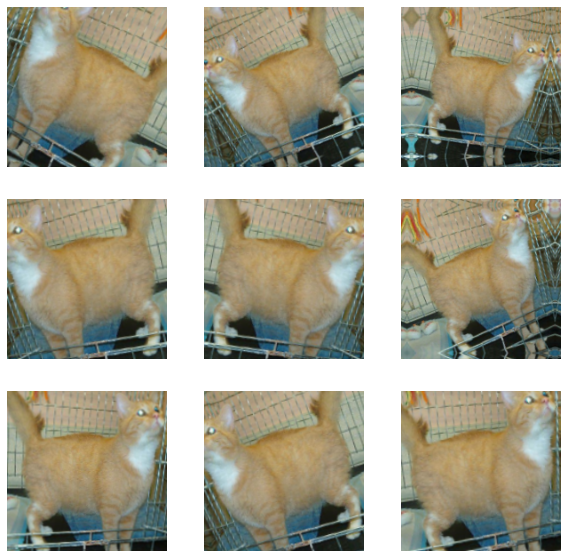

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

If we train a new network using this **data augmentation** configuration, our network will never see twice the same input. However, the inputs 
that it sees are still heavily intercorrelated, since they come from a small number of original images -- **we cannot produce new information**, 
we can only remix existing information. As such, this might not be quite enough to completely get rid of overfitting. To further fight 
overfitting, we will also add a **Dropout layer** to our model, right before the densely-connected classifier:

In [ ]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)

outputs = layers.Dense(1, activation="sigmoid")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

Let's train our network using data augmentation and dropout:

In [ ]:
history = model.fit(train_dataset,
                    epochs=100,
                    validation_data=validation_dataset)

Epoch 1/100
63/63 [==============================] - 8s 96ms/step - loss: 0.7210 - accuracy: 0.4930 - val_loss: 0.6883 - val_accuracy: 0.5000
Epoch 2/100
63/63 [==============================] - 6s 93ms/step - loss: 0.6957 - accuracy: 0.5035 - val_loss: 0.6887 - val_accuracy: 0.5080
Epoch 3/100
63/63 [==============================] - 6s 94ms/step - loss: 0.7263 - accuracy: 0.5655 - val_loss: 0.6652 - val_accuracy: 0.5690
Epoch 4/100
63/63 [==============================] - 6s 91ms/step - loss: 0.6744 - accuracy: 0.5780 - val_loss: 0.9758 - val_accuracy: 0.5020
Epoch 5/100
63/63 [==============================] - 6s 95ms/step - loss: 0.6900 - accuracy: 0.6120 - val_loss: 0.6331 - val_accuracy: 0.6680
Epoch 6/100
63/63 [==============================] - 9s 128ms/step - loss: 0.6498 - accuracy: 0.6390 - val_loss: 0.6746 - val_accuracy: 0.6190
Epoch 7/100
63/63 [==============================] - 6s 91ms/step - loss: 0.6286 - accuracy: 0.6435 - val_loss: 0.6140 - val_accuracy: 0.6550
Epoch

Let's save our model.

In [ ]:
model.save(os.path.join(dir_name, 'cats_and_dogs_small_augmentation.h5'))

Let's plot our results again:

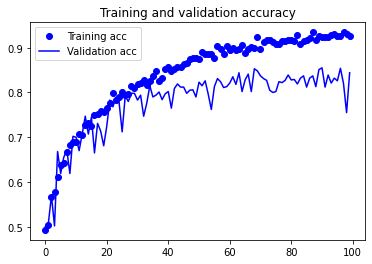

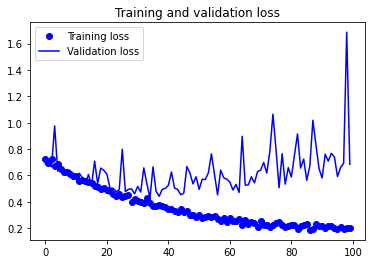

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Thanks to data augmentation and dropout, we have significantly reduced overfitting: the training curves are rather closely tracking the validation 
curves. We are now able to reach an accuracy of 80%-85%, almost 10% relative improvement over the non-regularized model.

By leveraging regularization techniques even further and by tuning the model's configuration (such as the number of filters per convolution 
layer, or the number of layers in the network), we may be able to get an even better accuracy, likely up to 90%. However, it would prove 
very difficult to go any higher just by training our own convnet from scratch, simply because we have so little data to work with. As a 
next step to improve our accuracy on this problem, we will have to leverage a pre-trained model, which will be the focus of the next notebook.